<a href="https://colab.research.google.com/github/tyoc213/fastai_xla_extensions/blob/explorations1/explore_nbs/Basic_lenet_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fastai2 from github

In [3]:
!pip install git+https://github.com/fastai/fastcore
!pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-7570ayf4
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-7570ayf4
  Created wheel for fastcore: filename=fastcore-0.1.18-cp36-none-any.whl size=28891 sha256=fd7dbfb54a1404410fc53106999eb2c3ac19240b9357c0c26c4bcf4a36867bf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-u0ypz3n8/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully built fastcore
  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-xqr0tee8
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-xqr0tee8
  Created wheel for fastai2: filename=fastai2-0.0.18-cp36-none-any.whl size=193924 sha256=3813ed2532bd3d1ae0501054abfd5f124aa419918d7175260ab1489ee5f1a02f
  Stored in directory: /tmp/pip-ephem-wheel-cache-80zj4g80/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


In [4]:
from fastai2.vision.all import *

[('__call__', <function LevelMapper.__call__ at 0x7fa74cf6f8c8>), ('__init__', <function LevelMapper.__init__ at 0x7fa74cf6f840>)]
[('__call__', <function BalancedPositiveNegativeSampler.__call__ at 0x7fa74ceaf488>), ('__init__', <function BalancedPositiveNegativeSampler.__init__ at 0x7fa74ceaf400>)]
[('__init__', <function BoxCoder.__init__ at 0x7fa74cebe8c8>), ('decode', <function BoxCoder.decode at 0x7fa74cebea60>), ('decode_single', <function BoxCoder.decode_single at 0x7fa74cebeae8>), ('encode', <function BoxCoder.encode at 0x7fa74cebe950>), ('encode_single', <function BoxCoder.encode_single at 0x7fa74cebe9d8>)]
[('__call__', <function Matcher.__call__ at 0x7fa74cebe7b8>), ('__init__', <function Matcher.__init__ at 0x7fa74cebebf8>), ('set_low_quality_matches_', <function Matcher.set_low_quality_matches_ at 0x7fa74cebe840>)]
[('__init__', <function ImageList.__init__ at 0x7fa74cebed90>), ('to', <function ImageList.to at 0x7fa74cebed08>)]
[('__init__', <function Timebase.__init__ at

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()[2].ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [6]:
def get_my_labels(fname):
    return int(fname.parent.name[0])

dblock = DataBlock(
    splitter = RandomSplitter(),
    #item_tfms = Resize(128),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = get_my_labels
)


In [46]:
dls_normal = dblock.dataloaders(path)
dls_normal.vocab

(#2) [3,7]

# Lenet with convs and F.max_pool2d

In [49]:
class MyLenet(nn.Module):
    def __init__(self):
        super(MyLenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.hiden4 = nn.Linear(400, 2) # 2 outputs instead of 10
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.hiden4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

lenet = MyLenet()
learn = Learner(dls_normal, lenet, metrics=[error_rate, accuracy])

learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.096945,0.064774,0.021137,0.978863,00:15


In [50]:
learn.validate()

(#3) [0.06477440148591995,0.02113652043044567,0.9788634777069092]

# Lenet with layers

In [51]:
class Lenet2(nn.Module):
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # Only 2 outputs instead of 10
    def forward(self, x):
        print(f"shapeeee {x.shape}")
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



lenet2 = Lenet2()
learn2 = Learner(dls_normal, lenet2, metrics=[error_rate, accuracy])

learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.066572,0.046531,0.014900,0.985101,00:16


shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
shapeeee torch.Size([64, 3, 28, 28])
s

In [52]:
learn.validate()

(#3) [0.06477440148591995,0.02113652043044567,0.9788634777069092]

# conectarse a TPU

In [12]:
VERSION = "20200325"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4139  100  4139    0     0  22133      0 --:--:-- --:--:-- --:--:-- 22015
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Uninstalling torch-1.6.0a0+bf2bbd9:
  Successfully uninstalled torch-1.6.0a0+bf2bbd9
Uninstalling torchvision-0.7.0a0+a6073f0:
  Successfully uninstalled torchvision-0.7.0a0+a6073f0
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
- [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.               

In [13]:
import torch_xla.core.xla_model as xm

class XLAOptFuncWrapper:
    def __init__(self, f):
        self.f = f
    def __call__(self, *args, **kwargs):
        opt = self.f(*args, **kwargs)
        optim_wrapper = OptimWrapper(opt)
        def xla_step():
            xm.optimizer_step(opt, barrier=True)
        # monkeypatch optim_wrapper with xla_step
        optim_wrapper.step = xla_step
        return optim_wrapper

# Load in TPU

In [33]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 14434 items
2 datasets of sizes 11548,2886
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_my_labels -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_sample/train/3/11010.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: get_my_labels -> Categorize
    starting from
      /root/.fastai/data/mnist_sample/train/3/11010.png
    applying get_my_labels gives
      3
    applying Categorize gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(0))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(0))
    applying ToTensor gives
      (TensorImage of size 3x28x28, TensorCategory

# Use TPU device

(None, (#2) [3,7])

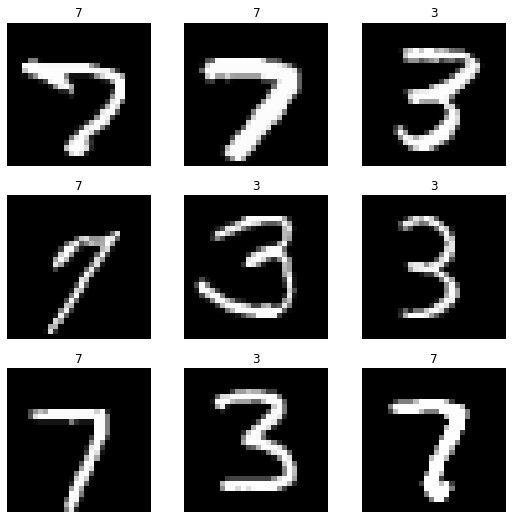

In [113]:
tpu_device = xm.xla_device()
dls_tpu = dblock.dataloaders(path, device=tpu_device)
dls_tpu.show_batch(), dls_tpu.vocab

In [114]:
dls_tpu.show([1])

In [61]:
sgd_xla_opt = XLAOptFuncWrapper(SGD)
adam_xla_opt = XLAOptFuncWrapper(Adam)


In [62]:
# from fastai2.callback.all import *
from fastai2.test_utils import *
lenet_tpu = Lenet2()
tpu_learner = Learner(dls_tpu, lenet_tpu, metrics=accuracy, 
                      loss_func=F.cross_entropy, opt_func=adam_xla_opt, cbs=VerboseCallback())

In [63]:
tpu_learner.summary()

shapeeee torch.Size([1, 3, 28, 28])


Lenet2 (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 6 x 26 x 26     168        True      
________________________________________________________________
Conv2d               64 x 16 x 11 x 11    880        True      
________________________________________________________________
Linear               64 x 120             48,120     True      
________________________________________________________________
Linear               64 x 84              10,164     True      
________________________________________________________________
Linear               64 x 2               170        True      
________________________________________________________________

Total params: 59,502
Total trainable params: 59,502
Total non-trainable params: 0

Optimizer used: <__main__.XLAOptFuncWrapper object at 0x7fa72ec3ca20>
Loss function: <function cross_entropy at 0x7fa75be6ec80>

Callbacks:
  - TrainEvalCallback
  

In [64]:
tpu_learner.show_training_loop()

Start Fit
   - begin_fit      : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - begin_epoch    : [Recorder, ProgressCallback]
    Start Train
       - begin_train    : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - begin_batch    : []
         - after_pred     : []
         - after_loss     : []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - begin_validate : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_cancel_epoch: []
   - after_epo

In [65]:
tpu_learner.fit(1)

begin_fit


begin_epoch
begin_train
begin_batch
shapeeee torch.Size([64, 3, 28, 28])
after_pred
after_loss
after_batch
after_train
after_epoch
after_fit


RuntimeError: ignored

In [66]:
tpu_learner.lr_find()

begin_fit


begin_epoch
begin_train
begin_batch
shapeeee torch.Size([64, 3, 28, 28])
after_pred
after_loss
after_batch
after_train
after_epoch
after_fit


RuntimeError: ignored

reference for https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward

In [96]:
ob = tpu_learner.dls.train.one_batch()
#print(ob)
len(ob), ob[0].shape, ob[1].shape, F.cross_entropy, tpu_learner.pred

(2,
 torch.Size([64, 3, 28, 28]),
 torch.Size([64]),
 <function torch.nn.functional.cross_entropy>,
 None)

In [109]:
def my_split(self__, b):
        i = getattr(self__.dls, 'n_inp', 1 if len(b)==1 else len(b)-1)
        self__.xb,self__.yb = b[:i],b[i:]
def my_one_batch(self__, i, b):
        print(f"self__={self__}")
        print(f"self__={dir(self__)}")
        self__.iter = i
        try:
            self__._split(b);                                  self__('begin_batch')
            self__.pred = self__.model(*self__.xb);                self__('after_pred')
            if len(self__.yb) == 0: return
            self__.loss = self__.loss_func(self__.pred, *self__.yb); self__('after_loss')
            if not self__.training: return
            self__.loss.backward();                            self__('after_backward')
            self__.opt.step();                                 self__('after_step')
            self__.opt.zero_grad()
        except CancelBatchException:                         self__('after_cancel_batch')
        finally:                                             self__('after_batch')

#my_one_batch(tpu_learner, 0, 64)
print(tpu_learner.splitter)
print(tpu_learner._split)

my_one_batch(tpu_learner, 0, 64)

<function trainable_params at 0x7fa75ae04268>
<bound method Learner._split of <fastai2.learner.Learner object at 0x7fa74c767358>>
self__=<fastai2.learner.Learner object at 0x7fa74c767358>
self__=['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_bn_bias_state', '_call_one', '_do_begin_fit', '_do_epoch_train', '_do_epoch_validate', '_end_cleanup', '_grab_cbs', '_metrics', '_split', 'add_cb', 'add_cbs', 'added_cbs', 'all_batches', 'cbs', 'create_mbar', 'create_opt', 'dl', 'dls', 'epoch', 'export', 'final_record', 'fine_tune', 'fit', 'fit_flat_cos', 'fit_one_cycle', 'fit_sgdr', 'freeze', 'freeze_to', 'gather_args', 'get_preds', 'init_args', 'iter', 'load', 'logger', 'loss', 'loss_func',

AttributeError: ignored

In [94]:
#the_loss = tpu_learner.loss_func(tpu_learner.pred, *tpu_learner.yb)
the_loss = tpu_learner.loss_func(tpu_learner.dls, *tpu_learner.yb)

AttributeError: ignored